0. 경로 설정

In [575]:
import os

os.getcwd()
base_dir = 'D:/Dacon_Art_Classification/Art_Classification'
data_dir = "D:/Dacon_Art_Classification/data"

0. Config Hyperparameter

In [576]:
class Config():
    def __init__(self):
        self.image_size = 224
        self.epochs = 30
        self.learning_rate = 3e-4
        self.batch_size = 64
        self.seed = 42
cfg = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

0. Random Seed 설정

In [577]:
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(cfg.seed) # Seed 고정

1. Dataset 만들기

In [578]:
import torch
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms
import torch.nn.functional as F
import pandas as pd
import numpy as np
import cv2

class CustomDataset(Dataset):
    
    def __init__(self, state,img_dir, label:pd.DataFrame=None, transform=None):
        self.state = state
        self.label = label
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        # linux일때 '/' 바꿔서 돌리기
        if self.state =='train':
            img_path = os.path.join(self.img_dir,"train",self.label['img_path'][idx].split('/')[-1])
            img_label = self.label['artist'][idx]
            img = cv2.imread(img_path)
            if self.transform:
                img = self.transform(img)    
            img_label = F.one_hot(torch.Tensor([img_label]).to(torch.int64),num_classes = 50)
            return img,img_label
        else:
            img_path = os.path.join(self.img_dir,"test",self.label['img_path'][idx].split('/')[-1])
            img = cv2.imread(img_path)
            #print(img_path)
            if self.transform:
                img = self.transform(img)
            return img
train_label = pd.read_csv(f'{data_dir}/train.csv')
test_label = pd.read_csv(f'{data_dir}/test.csv')

label_dict = dict(zip(train_label['artist'].unique(),range(50)))
label_dict_decode = dict(zip(range(50),train_label['artist'].unique()))
print(label_dict)

train_label['artist'] = [label_dict[i] for i in train_label['artist']]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop((224,224),scale = (0.25,1),ratio = (0.5,2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

{'Diego Velazquez': 0, 'Vincent van Gogh': 1, 'Claude Monet': 2, 'Edgar Degas': 3, 'Hieronymus Bosch': 4, 'Pierre-Auguste Renoir': 5, 'Rene Magritte': 6, 'Michelangelo': 7, 'Peter Paul Rubens': 8, 'Caravaggio': 9, 'Alfred Sisley': 10, 'Edouard Manet': 11, 'Rembrandt': 12, 'Francisco Goya': 13, 'Pablo Picasso': 14, 'Titian': 15, 'Mikhail Vrubel': 16, 'Leonardo da Vinci': 17, 'Kazimir Malevich': 18, 'Andy Warhol': 19, 'Vasiliy Kandinskiy': 20, 'Gustav Klimt': 21, 'Amedeo Modigliani': 22, 'Henri Rousseau': 23, 'Salvador Dali': 24, 'Pieter Bruegel': 25, 'Albrecht Du rer': 26, 'Paul Gauguin': 27, 'Sandro Botticelli': 28, 'Piet Mondrian': 29, 'Eugene Delacroix': 30, 'Paul Klee': 31, 'William Turner': 32, 'Marc Chagall': 33, 'Jan van Eyck': 34, 'Henri Matisse': 35, 'El Greco': 36, 'Gustave Courbet': 37, 'Andrei Rublev': 38, 'Jackson Pollock': 39, 'Edvard Munch': 40, 'Camille Pissarro': 41, 'Raphael': 42, 'Henri de Toulouse-Lautrec': 43, 'Joan Miro': 44, 'Giotto di Bondone': 45, 'Diego Rivera'

In [626]:
Custom_data = CustomDataset('train',data_dir,train_label,train_transform)
train_set_size = int(len(Custom_data) * 0.8)
valid_set_size = int(len(Custom_data)-train_set_size )

train_set, valid_set = random_split(Custom_data, [train_set_size, valid_set_size])

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=64, shuffle=True)

test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)


2. 모델 만들기

In [627]:
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        #num_ftrs = self.backbone.fc.in_features
        #self.backbone.fc = nn.Sequential()
        #self.classifier = nn.Sequential(
        #    nn.Linear(num_ftrs,200,bias=True),
        #    nn.ReLU(inplace=True),
        #    nn.Dropout(0.5,inplace = True),
        #    nn.Linear(200, 50, bias=True))
        self.classifier = nn.Linear(1000, 50)

    def forward(self,x):
        x = self.backbone(x)
        x = self.classifier(x)
        x = torch.nn.functional.sigmoid(x)
        #x = torch.nn.functional.softmax(x,dim=0)
        return x


In [628]:
#from torchvision.models import resnet50, ResNet50_Weights
#import torch.nn as nn
#model_pretrained = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

#num_ftrs = model_pretrained.fc.in_features

#model_pretrained.fc = nn.Sequential(
#    nn.Linear(num_ftrs,200,bias=True),
#    nn.ReLU(inplace=True),
#    nn.Linear(200, 50),
#    nn.ReLU(inplace=True))
#print(model_pretrained)
#이거 쓰는 법도 공부해보기

3. 학습시키기

In [629]:
import tqdm
from sklearn.metrics import f1_score   

def train(model,num_epoch, cirterion, optimizer, train_dataloader, valid_dataloader, scheduler, device): 
    train_loss_history = []
    valid_loss_history = []
    best_score = 0
    best_model = None
    
    for epoch in range(num_epoch):
        print("epoch is :",epoch)
        model.train()
        train_loss = []
        for i, (images,labels) in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device) # one hot 인코딩이 아닐시에 tensor 처리 안해도 됨
            outputs = model(images)
            loss = criterion(outputs, labels.reshape(-1,50).float()) # one hot 인코딩이 아닐시에 reshape 처리 안해도 됨
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_loss_history.append(np.mean(train_loss))
        val_loss,val_score = validation(model, criterion, valid_dataloader, device)
        valid_loss_history.append(val_loss)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        #print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}]')    
        if scheduler is not None:
            scheduler.step()
            
        #if best_score < val_score:
        #    best_model = model
        #    best_score = val_score
        
    return model, train_loss_history, valid_loss_history
def validation(model, criterion, data_loader, device):
    model.eval()
    model_preds = []
    true_labels = []
    val_loss = []
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img, label = img.to(device), label.to(device).reshape(-1,50).float()
            
            model_pred = model(img)
            
            loss = criterion(model_pred,label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist() #index 뽑기
            true_labels += label.argmax(1).detach().cpu().numpy().tolist()
            
    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

from sklearn.metrics import f1_score
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro") 
        
            

In [630]:
model = ResNet()
for name, param in model.named_parameters():
    print(name)

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.1.conv1.weight
backbone.layer1.1.bn1.weight
backbone.layer1.1.bn1.bias
backbone.layer1.1.conv2.weight
backbone.layer1.1.bn2.weight
backbone.layer1.1.bn2.bias
backbone.layer1.1.conv3.weight
backbone.layer1.1.bn3.weight
backbone.layer1.1.bn3.bias
backbone.layer1.2.conv1.weight
backbone.layer1.2.bn1.weight
backbone.layer1.2.bn1.bias
backbone.layer1.2.conv2.weight
backbone.layer1.2.bn2.weight
backbone.layer1.2.bn2.bias
backbone.layer1.2.conv3.weight
backbone.layer1.2.bn3.weight
backbone.layer1.2.bn3.bias
backbone.layer2.0.conv1.weight
backbone.layer

Freezing 학습시키기

In [633]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score   

model = ResNet()
for name, param in model.named_parameters():
    if 'backbone' in name:
        param.requires_grad = False
    elif 'fc' in name:
        param.requires_grad = True
        
model.to(device)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = None
infer_model,train_history, valid_history = train(model, 5, criterion, optimizer, train_dataloader, valid_dataloader, scheduler, device)


epoch is : 0


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.11it/s]


Epoch [0], Train Loss : [0.93384] Val Loss : [0.90774] Val F1 Score : [0.02557]
epoch is : 1


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.10it/s]


Epoch [1], Train Loss : [0.88310] Val Loss : [0.86458] Val F1 Score : [0.04009]
epoch is : 2


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.11it/s]


Epoch [2], Train Loss : [0.84730] Val Loss : [0.83259] Val F1 Score : [0.04471]
epoch is : 3


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.11it/s]


Epoch [3], Train Loss : [0.82187] Val Loss : [0.81477] Val F1 Score : [0.06154]
epoch is : 4


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.10it/s]

Epoch [4], Train Loss : [0.80381] Val Loss : [0.80152] Val F1 Score : [0.07006]


In [642]:
test_model = ResNet()
#for name, param in model.named_parameters():
#    if 'backbone' in name:
#        param.requires_grad = False
#    elif 'fc' in name:
#        param.requires_grad = True
        
import torchsummary
torchsummary.summary(test_model,(3,224,224))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [634]:
for name, param in infer_model.named_parameters():
    param.requires_grad = True
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = None
infer_model,train_history, valid_history = train(infer_model, 10, criterion, optimizer, train_dataloader, valid_dataloader, scheduler, device)


epoch is : 0


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.11it/s]


Epoch [0], Train Loss : [0.69586] Val Loss : [0.69317] Val F1 Score : [0.02816]
epoch is : 1


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.08it/s]


Epoch [1], Train Loss : [0.69316] Val Loss : [0.69316] Val F1 Score : [0.02538]
epoch is : 2


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.05it/s]


Epoch [2], Train Loss : [0.69316] Val Loss : [0.69316] Val F1 Score : [0.02706]
epoch is : 3


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.02it/s]


Epoch [3], Train Loss : [0.69315] Val Loss : [0.69315] Val F1 Score : [0.02109]
epoch is : 4


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.04it/s]


Epoch [4], Train Loss : [0.69315] Val Loss : [0.69315] Val F1 Score : [0.03202]
epoch is : 5


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.02it/s]


Epoch [5], Train Loss : [0.69315] Val Loss : [0.69315] Val F1 Score : [0.02972]
epoch is : 6


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.02it/s]


Epoch [6], Train Loss : [0.69315] Val Loss : [0.69315] Val F1 Score : [0.03387]
epoch is : 7


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch [7], Train Loss : [0.69315] Val Loss : [0.69315] Val F1 Score : [0.03169]
epoch is : 8


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.02it/s]


Epoch [8], Train Loss : [0.69315] Val Loss : [0.69315] Val F1 Score : [0.02284]
epoch is : 9


  0%|                                                                                           | 0/74 [00:00<?, ?it/s]C:\Users\kimju\anaconda3\envs\dacon\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.03it/s]

Epoch [9], Train Loss : [0.69315] Val Loss : [0.69315] Val F1 Score : [0.03472]


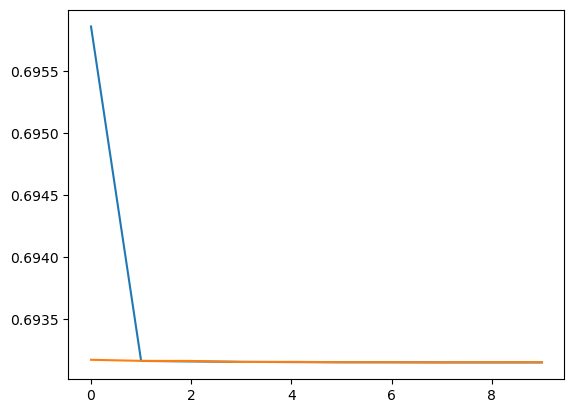

In [635]:
plt.plot(train_history)
plt.plot(valid_history)

In [481]:
torch.save(infer_model,"pretrained_model.pt")

PicklingError: Can't pickle <class '__main__.ResNet'>: it's not the same object as __main__.ResNet

In [552]:
import torch
from tqdm import tqdm
from torchvision import transforms
test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])
#valid_model = torch.load('model.pt')
valid_model = infer_model
valid_model.eval()
out_list = []
label_list= []
with torch.no_grad():
    for i,(image,label) in enumerate(tqdm(valid_dataloader)):
        image = image.to(device)
        out = valid_model(image)
        out_list.append(out)
        label_list.append(label)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.22it/s]


In [555]:
print(len(label_list[0]))
k = [np.argmax(i,axis=2).flatten() for i in label_list]
final_label = []
for i in k:
    final_label+=i
final_label = [i.item() for i in final_label]
print(len(final_label))

64
1183


In [554]:
final_label = []
for i in label_list:
    for j in i:
        final_label.append(j.item())
print(len(final_label))

ValueError: only one element tensors can be converted to Python scalars

In [556]:
final_class = [(i.argmax(axis=1).to('cpu')) for i in out_list]
final_output = []
for i in final_class:
    for j in i:
        final_output.append(j.item())
print(final_output)

[10, 14, 5, 25, 20, 15, 10, 3, 48, 40, 24, 21, 5, 21, 6, 5, 2, 1, 14, 3, 28, 20, 35, 6, 35, 21, 19, 45, 1, 5, 33, 12, 41, 38, 18, 27, 35, 33, 13, 26, 34, 6, 22, 15, 36, 15, 29, 3, 3, 28, 1, 5, 1, 47, 3, 34, 20, 1, 26, 35, 44, 44, 45, 46, 0, 35, 28, 12, 1, 14, 3, 1, 4, 3, 11, 1, 49, 8, 24, 32, 26, 16, 31, 4, 6, 19, 13, 46, 40, 8, 3, 26, 10, 38, 14, 13, 1, 22, 3, 3, 39, 5, 12, 1, 24, 17, 14, 15, 49, 10, 1, 3, 47, 27, 44, 25, 14, 0, 4, 25, 10, 25, 3, 20, 27, 13, 1, 18, 1, 1, 1, 0, 35, 3, 17, 16, 46, 3, 26, 10, 3, 41, 1, 19, 7, 15, 33, 14, 1, 20, 19, 21, 41, 20, 33, 41, 12, 10, 3, 18, 27, 4, 44, 37, 13, 1, 22, 1, 13, 18, 0, 20, 4, 16, 10, 8, 8, 24, 13, 1, 5, 6, 27, 3, 23, 14, 29, 1, 6, 17, 43, 1, 3, 47, 19, 4, 3, 26, 1, 1, 21, 13, 44, 28, 26, 37, 3, 3, 36, 33, 35, 10, 25, 26, 3, 31, 18, 31, 17, 38, 15, 27, 1, 35, 27, 1, 49, 3, 21, 25, 1, 35, 1, 17, 27, 31, 3, 27, 5, 13, 35, 15, 43, 4, 31, 5, 36, 47, 25, 14, 3, 22, 6, 3, 5, 14, 7, 42, 14, 3, 8, 35, 1, 46, 1, 13, 8, 3, 26, 3, 6, 15, 24, 42, 

In [557]:
from sklearn.metrics import f1_score
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

In [558]:
score = competition_metric(final_label,final_output)
print(score)

0.698742308813219


In [522]:
%matplotlib inline
import sklearn
cm = sklearn.metrics.confusion_matrix(final_label,final_output)
sklearn.metrics.ConfusionMatrixDisplay(cm)

ValueError: Found input variables with inconsistent numbers of samples: [0, 1183]

In [559]:
import torch
from tqdm import tqdm
from torchvision import transforms
test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])
#valid_model = torch.load('model.pt')
test_model = infer_model
test_model.eval()
model_preds = []
with torch.no_grad():
    for i,image in enumerate(tqdm(test_dataloader)):
        image = image.to(device)
        model_pred = test_model(image)
        model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
print('Done')

100%|████████████████████████████████████████████████████████████████████████████████| 396/396 [01:32<00:00,  4.28it/s]

Done


In [560]:
submit = pd.read_csv(f'{data_dir}/sample_submission.csv')
submit['artist'] = model_preds
submit['artist'] = [label_dict_decode[i] for i in submit['artist']]
submit.to_csv('submission.csv', index=False)

In [561]:
print(model_preds)

[24, 27, 24, 26, 27, 6, 10, 27, 6, 25, 26, 6, 6, 27, 26, 34, 24, 26, 6, 6, 6, 6, 10, 13, 27, 5, 1, 27, 6, 21, 27, 21, 35, 29, 1, 27, 27, 19, 35, 21, 6, 26, 21, 21, 6, 6, 6, 6, 27, 3, 41, 10, 13, 10, 26, 27, 42, 26, 6, 26, 6, 27, 27, 26, 6, 21, 6, 6, 27, 6, 27, 26, 24, 27, 6, 10, 27, 27, 26, 21, 29, 6, 27, 10, 21, 6, 6, 6, 21, 27, 6, 10, 6, 6, 16, 16, 26, 10, 21, 10, 27, 6, 6, 26, 24, 6, 10, 26, 10, 26, 6, 21, 6, 35, 6, 6, 6, 6, 27, 41, 19, 27, 27, 32, 6, 6, 26, 10, 24, 26, 41, 6, 29, 26, 24, 26, 6, 10, 21, 26, 10, 21, 26, 26, 10, 3, 35, 6, 6, 10, 10, 10, 3, 26, 6, 6, 26, 6, 10, 6, 26, 26, 10, 26, 27, 26, 26, 21, 27, 27, 1, 26, 21, 27, 6, 10, 16, 26, 26, 21, 6, 6, 2, 21, 26, 27, 27, 26, 27, 3, 16, 27, 35, 26, 26, 26, 27, 27, 15, 27, 6, 26, 29, 13, 10, 6, 10, 16, 6, 10, 26, 21, 6, 26, 10, 26, 6, 6, 21, 3, 26, 6, 6, 21, 16, 10, 10, 10, 26, 26, 6, 16, 27, 27, 5, 27, 21, 6, 27, 35, 6, 27, 29, 10, 21, 27, 3, 6, 27, 21, 25, 21, 6, 34, 6, 16, 6, 6, 10, 6, 24, 10, 21, 6, 10, 31, 10, 10, 6, 3, 2

In [80]:
label_dict_decode

{0: 'Diego Velazquez',
 1: 'Vincent van Gogh',
 2: 'Claude Monet',
 3: 'Edgar Degas',
 4: 'Hieronymus Bosch',
 5: 'Pierre-Auguste Renoir',
 6: 'Rene Magritte',
 7: 'Michelangelo',
 8: 'Peter Paul Rubens',
 9: 'Caravaggio',
 10: 'Alfred Sisley',
 11: 'Edouard Manet',
 12: 'Rembrandt',
 13: 'Francisco Goya',
 14: 'Pablo Picasso',
 15: 'Titian',
 16: 'Mikhail Vrubel',
 17: 'Leonardo da Vinci',
 18: 'Kazimir Malevich',
 19: 'Andy Warhol',
 20: 'Vasiliy Kandinskiy',
 21: 'Gustav Klimt',
 22: 'Amedeo Modigliani',
 23: 'Henri Rousseau',
 24: 'Salvador Dali',
 25: 'Pieter Bruegel',
 26: 'Albrecht Du rer',
 27: 'Paul Gauguin',
 28: 'Sandro Botticelli',
 29: 'Piet Mondrian',
 30: 'Eugene Delacroix',
 31: 'Paul Klee',
 32: 'William Turner',
 33: 'Marc Chagall',
 34: 'Jan van Eyck',
 35: 'Henri Matisse',
 36: 'El Greco',
 37: 'Gustave Courbet',
 38: 'Andrei Rublev',
 39: 'Jackson Pollock',
 40: 'Edvard Munch',
 41: 'Camille Pissarro',
 42: 'Raphael',
 43: 'Henri de Toulouse-Lautrec',
 44: 'Joan Mi

In [247]:
# epoch = 10, f1_score = 0.6480124118321071

In [411]:
len(this[this['artist'] == i])

33

In [414]:
 this = pd.read_csv(f'{data_dir}/train.csv')
for i in this['artist'].unique():
    count = len(this[this['artist'] == i])
    print(f'{i} : {count}')

Diego Velazquez : 81
Vincent van Gogh : 629
Claude Monet : 59
Edgar Degas : 490
Hieronymus Bosch : 115
Pierre-Auguste Renoir : 233
Rene Magritte : 137
Michelangelo : 34
Peter Paul Rubens : 97
Caravaggio : 32
Alfred Sisley : 164
Edouard Manet : 62
Rembrandt : 181
Francisco Goya : 204
Pablo Picasso : 303
Titian : 173
Mikhail Vrubel : 118
Leonardo da Vinci : 101
Kazimir Malevich : 91
Andy Warhol : 132
Vasiliy Kandinskiy : 60
Gustav Klimt : 69
Amedeo Modigliani : 132
Henri Rousseau : 52
Salvador Dali : 99
Pieter Bruegel : 85
Albrecht Du rer : 220
Paul Gauguin : 220
Sandro Botticelli : 120
Piet Mondrian : 59
Eugene Delacroix : 26
Paul Klee : 142
William Turner : 44
Marc Chagall : 173
Jan van Eyck : 64
Henri Matisse : 121
El Greco : 65
Gustave Courbet : 42
Andrei Rublev : 74
Jackson Pollock : 21
Edvard Munch : 44
Camille Pissarro : 64
Raphael : 73
Henri de Toulouse-Lautrec : 61
Joan Miro : 76
Giotto di Bondone : 72
Diego Rivera : 50
Frida Kahlo : 84
Georges Seurat : 30
Paul Cezanne : 33
